In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from Bio import SeqIO, Seq

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics
from sklearn.decomposition import PCA
import timeit
import scipy.stats as st
import pickle, yaml, tracemalloc
from scipy.stats import binomtest
import statsmodels.api as sm

# eigenvec_df = pd.read_csv("data/eigenvec_100PC.csv").set_index("sample_id")
pca_explained_var = np.load("data/pca_explained_var.npy")
who_variants_combined = pd.read_csv("analysis/who_confidence_2021.csv")

sample_ids_mapping = pd.read_csv("data/sample_ids_mapping.csv")
samples_summary = pd.read_csv("data/samples_summary.csv")
drug_CC = pd.read_csv("data/drug_CC.csv")
overview_MIC_data_dict = pd.read_excel("data/overview_MIC_data.xlsx", sheet_name=None)
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
input_data_dir = '/n/data1/hms/dbmi/farhat/ye12/who'
drug_gene_mapping = pd.read_csv("data/drug_gene_mapping.csv")

who_variants_combined = pd.read_csv("analysis/who_confidence_2021.csv")

# utils files are in the utils_files folder
sys.path.append("utils")
from data_utils import *
from stats_utils import *

lineages = pd.read_csv("data/lineages.csv", low_memory=False)

In [31]:
inh_results = pd.read_excel("results/BINARY/Isoniazid.xlsx", sheet_name=None)

In [32]:
compens_lst = ['c.-47_-46insT', 'c.-48G>A', 'c.-51G>A', 'c.-81C>T', 'c.-76T>A', 'c.-57C>T', 'c.-52C>T', 'c.-88_-87insAT', 'c.-77T>G', 'c.-72C>T', 'c.-54C>T', 'c.-74G>A', 'c.-52C>A']
compens_lst = ["ahpC_" + val for val in compens_lst]

# 'c.-42T>C' not in dataset, but 'c.-42T>G' is
neutral_lst = ['c.-88G>A', 'c.-84T>C', 'c.-42T>C', 'c.-42T>G', 'c.-88G>A', 'c.-46G>A', 'c.-10G>A', 'c.33G>A']
neutral_lst = ["ahpC_" + val for val in neutral_lst]

print(len(compens_lst), len(neutral_lst))

13 8


In [33]:
inh_results["Model_3"].query("mutation.isin(@compens_lst)")["regression_confidence"].value_counts()

Assoc w R - strict        5
Assoc w R                 5
Evidence against Assoc    3
Name: regression_confidence, dtype: int64

In [34]:
inh_results["Model_3"].query("mutation.isin(@neutral_lst)")["regression_confidence"].value_counts()

Evidence against Assoc    4
Name: regression_confidence, dtype: int64

In [35]:
inh_results["Model_3"].query("mutation.isin(@compens_lst)").sort_values("mutation")[["mutation", "predicted_effect", "position", "confidence_V1", "Odds_Ratio", "OR_LB", "OR_UB", "BH_pval", "PPV_LB", "Num_Isolates", "LRT_BH_pval", "regression_confidence"]]

,mutation,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,BH_pval,PPV_LB,Num_Isolates,LRT_BH_pval,regression_confidence
53,ahpC_c.-47_-46insT,upstream_gene_variant,2726146,3) Uncertain significance,1.063391,1.052283,1.076212,0.000000,0.897182,34.0,0.988430,Assoc w R
11,ahpC_c.-48G>A,upstream_gene_variant,2726145,3) Uncertain significance,1.177554,1.106376,1.252993,0.000000,0.884434,121.0,0.001040,Assoc w R - strict
73,ahpC_c.-51G>A,upstream_gene_variant,2726142,3) Uncertain significance,1.054542,0.987136,1.132041,0.005049,0.635816,56.0,1.000000,Assoc w R
40,ahpC_c.-52C>A,upstream_gene_variant,2726141,3) Uncertain significance,1.071485,1.006184,1.155561,0.000000,0.803227,34.0,0.385443,Assoc w R
17,ahpC_c.-52C>T,upstream_gene_variant,2726141,3) Uncertain significance,1.133538,1.054025,1.199831,0.000000,0.768474,64.0,0.000964,Assoc w R - strict
20,ahpC_c.-54C>T,upstream_gene_variant,2726139,3) Uncertain significance,1.122787,1.058480,1.168153,0.000000,0.757102,27.0,0.036705,Assoc w R - strict
12,ahpC_c.-57C>T,upstream_gene_variant,2726136,3) Uncertain significance,1.172843,1.117081,1.212318,0.000000,0.846732,34.0,0.000002,Assoc w R - strict
133,ahpC_c.-72C>T,upstream_gene_variant,2726121,3) Uncertain significance,1.044559,1.002694,1.090452,0.005049,0.580934,21.0,0.568587,Assoc w R
522,ahpC_c.-74G>A,upstream_gene_variant,2726119,3) Uncertain significance,1.012404,0.998669,1.042121,0.515733,0.473490,8.0,1.000000,Evidence against Assoc
15,ahpC_c.-76T>A,upstream_gene_variant,2726117,3) Uncertain significance,1.137640,1.090863,1.175146,0.000000,0.823533,19.0,0.000036,Assoc w R - strict


In [36]:
inh_results["Model_3"].query("mutation.isin(@neutral_lst)").sort_values("mutation")[["mutation", "predicted_effect", "position", "confidence_V1", "Odds_Ratio", "OR_LB", "OR_UB", "BH_pval", "PPV_LB", "Num_Isolates", "LRT_BH_pval", "regression_confidence"]]

,mutation,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,BH_pval,PPV_LB,Num_Isolates,LRT_BH_pval,regression_confidence
1210,ahpC_c.-10G>A,upstream_gene_variant,2726183,NaN,0.983347,0.973404,1.000000,0.562238,0.158114,2.0,1.0,Evidence against Assoc
668,ahpC_c.-42T>G,upstream_gene_variant,2726151,3) Uncertain significance,1.007639,1.000000,1.015626,0.562238,0.025000,1.0,1.0,Evidence against Assoc
1171,ahpC_c.-84T>C,upstream_gene_variant,2726109,3) Uncertain significance,0.985015,0.975616,1.000000,0.562238,0.158114,2.0,1.0,Evidence against Assoc
1334,ahpC_c.-88G>A,upstream_gene_variant,2726105,5) Not assoc w R,0.952190,0.883199,1.024105,0.288857,0.753147,4201.0,1.0,Evidence against Assoc


# Create Combined Lineages File

In [65]:
def combine_lineages_with_sampleIDs(lineages_fName, sample_ids_mapping):
    
    lineages_df = pd.read_csv(lineages_fName, low_memory=False)
    lineages_df["Sample Name"] = [name.split("-")[0] for name in lineages_df["File_Name"]]
    lineages_df = lineages_df.merge(sample_ids_mapping, on="Sample Name", how="inner")

    lineages_df = lineages_df.dropna(axis=1, how="all").reset_index(drop=True)
    lineages_df = lineages_df[lineages_df.columns[~lineages_df.columns.str.startswith("Count")]]
    
    # remove count strings from the original Lineage field
    for i, row in lineages_df.iterrows():
    
        lineage = row["Lineage"]

        if type(lineage) == str:
            remove_start_idx = list(lineage).index("(")
            lineages_df.loc[i, "Lineage"] = lineage[:remove_start_idx]
        
    # the null ones are all some combination of canetti, westafrican, ethiopian, tur, mungi. There are only ~10-15 of these, so drop
    # null means it couldn't e classified in the Coll 2014 scheme, but other columns are not null because a different scheme classified them
    lineages_df = lineages_df.loc[~pd.isnull(lineages_df["Lineage_1"])]
    
    # multiple directories contain the same VCF files, so drop duplicates here
    lineages_df = lineages_df.sort_values("Lineage", ascending=True).drop_duplicates(subset=["Sample Name", "Sample ID", "Lineage"], keep="first")
    return lineages_df

In [66]:
lineages_df = combine_lineages_with_sampleIDs("data/lineages_2.csv", sample_ids_mapping)
lineages_df.shape

(65786, 12)

In [67]:
lineages_df

,VCF_Dir,File_Name,Lineage,Lineage_1,Lineage_2,Lineage_3,Lineage_4,Lineage_5,Lineage_6,Lineage_7,Sample Name,Sample ID
16124,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/SA...,SAMEA7549478-freebayes.vcf,1,1,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA7549478,18203
32832,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/74...,SAMN07765885-freebayes.vcf,1,1,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07765885,142389
55925,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/99...,SPE_6B1800_300F25114DF9-freebayes.vcf,1,1,NaN,NaN,NaN,NaN,NaN,NaN,SPE_6B1800_300F25114DF9,169106
34712,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/f8...,SAMEA3558121-freebayes.vcf,1,1,2.2.1,NaN,NaN,NaN,NaN,NaN,SAMEA3558121,63999
24166,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/21...,2108208010-freebayes.vcf,1,1,NaN,NaN,NaN,NaN,NaN,NaN,2108208010,790022
...,...,...,...,...,...,...,...,...,...,...,...,...
29155,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/SA...,SAMEA7551661-freebayes.vcf,BOV_AFRI,BOV_AFRI,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA7551661,16023
13404,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/b8...,SAMN07660133-freebayes.vcf,BOV_AFRI,BOV_AFRI,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07660133,96754
12035,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/a7...,SPE_6B1800_F3B837D0FFA3-freebayes.vcf,BOV_AFRI,BOV_AFRI,NaN,NaN,NaN,NaN,NaN,NaN,SPE_6B1800_F3B837D0FFA3,170543
46975,/n/data1/hms/dbmi/farhat/ye12/who/vcf_files/SA...,SAMEA7549141-freebayes.vcf,BOV_AFRI,BOV_AFRI,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA7549141,18539


In [ ]:
# for _, row in lineages_df.loc[pd.isnull(lineages_df["Lineage_1"])].reset_index(drop=True).iterrows():
    
#     fName = row["VCF_Dir"] + "/" + row["File_Name"]

#     proc = subprocess.Popen(f"fast-lineage-caller {fName} --noheader --count --pass", shell=True, encoding='utf8', stdout=subprocess.PIPE)
#     output = proc.communicate()[0]

#     # output order: Isolate, coll2014, freschi2020, lipworth2019, shitikov2017, stucki2016 
#     print(output.split("\t")[3])

canetti(6734/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6736/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6734/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6724/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6738/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6733/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6728/6745),westafrican1(1/643),ethiopian(1/806),east_african_indian(1/231),tur(1/43),mungi(1/595)
canetti(6737/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6733/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6730/6745),suricattae(1/505),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6730/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)
canetti(6732/6745),westafrican1(1/643),ethiopian(1/806),tur(1/43),mungi(1/595)


# New Lineage Structure Correction

Perhaps we should do a test of univariate association between all PCs individually and the phenotype and select those that have P-value <0.1 or something before including them in the model, as opposed to just including the top n PCs in terms of variance.

In [37]:
coll2014 = pd.read_csv("data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)

coll2014.query("Lineage.str.startswith('2.2.1')")

,Lineage,position,allele_change,tag
11,2.2.1,797736,C/T,coll2014
12,2.2.1.1,4248115,C/T,coll2014
13,2.2.1.2,3836274,G/A,coll2014


In [38]:
# minor allele counts dataframe for all samples
minor_allele_counts = pd.read_pickle("data/minor_allele_counts.pkl")

L2_samples = minor_allele_counts.loc[minor_allele_counts[coll2014.set_index("Lineage").loc["2", "position"]]==1].index.values
L221_samples = minor_allele_counts.loc[minor_allele_counts[coll2014.set_index("Lineage").loc["2.2.1", "position"]] == 1].index.values
print(len(L2_samples), len(L221_samples))

16843 15650


In [45]:
model_matrix.query("index in @L221_samples").to_pickle(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix_L2.2.1.pkl"))

In [42]:
pheno_category_lst = ["WHO"]
drug = "Bedaquiline"

if "ALL" in pheno_category_lst:
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=ALL/dropAF_noSyn_unpooled/model_matrix.pkl"))
else:
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_matrix.pkl"))
    
# print(model_matrix.shape)
# df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).set_index("sample_id").query("phenotypic_category in @pheno_category_lst")
# eigenvec_df = pd.read_csv("data/eigenvec_20PC.csv").set_index("sample_id")

# # model_matrix = model_matrix.merge(minor_allele_counts, left_index=True, right_index=True)
# model_matrix = model_matrix.merge(eigenvec_df, left_index=True, right_index=True)

# # keep only samples (rows) that are in matrix and use loc with indices to ensure they are in the same order
# df_phenos = df_phenos.loc[model_matrix.index]
# print(df_phenos.shape)

# # check that the sample ordering is the same in the genotype and phenotype matrices
# assert sum(model_matrix.index != df_phenos.index) == 0

In [24]:
L221_BDQ = model_matrix.query("index in @L221_samples")
df_phenos_L221 = df_phenos.loc[L221_BDQ.index]

L2_BDQ = model_matrix.query("index in @L2_samples")
df_phenos_L2 = df_phenos.loc[L2_BDQ.index]

# check that the sample ordering is the same in the genotype and phenotype matrices
assert sum(L221_BDQ.index != df_phenos_L221.index) == 0
assert sum(L2_BDQ.index != df_phenos_L2.index) == 0
print(L221_BDQ.shape, L2_BDQ.shape)

(4817, 641) (5432, 641)


In [25]:
pd.DataFrame(L221_BDQ.merge(df_phenos_L221, left_index=True, right_index=True).groupby(["mmpS5_c.-74G>T", "phenotype"])["phenotype"].count())

phenotype
mmpS5_c.-74G>T phenotype           
0.0            0               4518
               1                168
1.0            0                 94
               1                 37

In [332]:
TP = 36
FP = 3
TN = 550
FN = 118

# probability that an isolate WITH mutation is RESISTANT
print(f"PPV = {np.round(TP / (TP + FP), 2)}")

# probability that an isolate WITHOUT mutation is SUSCEPTIBLE
print(f"NPV = {np.round(TN / (TN + FN), 2)}")

# probability that a RESISTANT isolate HAS the mutation
print(f"Sens = {np.round(TP / (TP + FN), 2)}")

# probability that a SUSCEPTIBLE isolate DOES NOT HAVE the mutation
print(f"Spec = {np.round(TN / (TN + FP), 2)}")

PPV = 0.92
NPV = 0.82
Sens = 0.23
Spec = 0.99


In [333]:
TP = 37
FP = 94
TN = 4518
FN = 168

# probability that an isolate WITH mutation is RESISTANT
print(f"PPV = {np.round(TP / (TP + FP), 2)}")

# probability that an isolate WITHOUT mutation is SUSCEPTIBLE
print(f"NPV = {np.round(TN / (TN + FN), 2)}")

# probability that a RESISTANT isolate HAS the mutation
print(f"Sens = {np.round(TP / (TP + FN), 2)}")

# probability that a SUSCEPTIBLE isolate DOES NOT HAVE the mutation
print(f"Spec = {np.round(TN / (TN + FP), 2)}")

PPV = 0.28
NPV = 0.96
Sens = 0.18
Spec = 0.98


In [27]:
37/(37+94)

0.2824427480916031

In [368]:
df_mic =  pd.read_csv(os.path.join(analysis_dir, drug, "phenos_mic.csv"))
print(df_mic.shape)

def process_mics(df_phenos):
    
    # general hierarchy: solid > liquid > plates
    # MABA, Frozen Broth Microdilution Plate (PMID31969421), UKMYC5, UKMYC6, and REMA are plates
    # 7H9 is a liquid media
    media_lst = ["7H10", "LJ", "7H11", "MGIT", "MODS", "BACTEC", "7H9", "Frozen Broth Microdilution Plate (PMID31969421)", "UKMYC6", "UKMYC5", 
                 "REMA", "MYCOTB", "MABA", "MABA24", "MABA48", "non-colourmetric", "M24 BMD"]

    media_hierarchy = dict(zip(media_lst, np.arange(len(media_lst))+1))
    
    # check that no media are missing from either
    if len(set(df_phenos.medium.values) - set(media_hierarchy.keys())) > 0:
        raise ValueError(f"{set(df_phenos.medium.values).symmetric_difference(set(media_hierarchy.keys()))} media are different between df_phenos and media_hierarchy")
    # add media hierarchy to dataframe, sort so that the highest (1) positions come first, then drop duplicates so that every sample has a single MIC
    else:
        df_phenos["media_hierarchy_pos"] = df_phenos["medium"].map(media_hierarchy)
        df_phenos = df_phenos.sort_values("media_hierarchy_pos", ascending=True).drop_duplicates(["sample_id", "mic_value"], keep="first").reset_index(drop=True)
        del df_phenos["media_hierarchy_pos"]
        assert len(df_phenos) == len(df_phenos["sample_id"].unique())
        
    return df_phenos

df_mic = process_mics(df_mic)

model_matrix_MIC = pd.read_pickle(os.path.join(analysis_dir, "Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_matrix.pkl")).merge(eigenvec_df, left_index=True, right_index=True)
model_matrix_MIC = model_matrix_MIC.query("index in @L221_samples")

df_mic = df_mic.set_index("sample_id").loc[model_matrix_MIC.index, :]
print(model_matrix_MIC.shape, df_mic.shape)

(12580, 7)
(4167, 571) (4167, 6)


In [373]:
res_mic = fit_single_regression(model_matrix_MIC, df_mic, binary=False)

4167 samples and 571 variables in the model
           mutation      coef
440  mmpS5_c.-74G>T  0.008736


In [375]:
res_mic.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,neutral_pval,BH_pval,Bonferroni_pval,neutral_BH_pval,neutral_Bonferroni_pval,confidence
440,mmpS5_c.-74G>T,0.008736,-0.0413,0.061169,0.26,0.4,1.0,1.0,0.490129,1.0,3) Uncertain significance


In [309]:
L2_BDQ.merge(df_phenos_L2, left_index=True, right_index=True).groupby("mmpS5_c.-74G>T")["phenotype"].mean()

mmpS5_c.-74G>T
0.0    0.081494
1.0    0.282443
Name: phenotype, dtype: float64

In [302]:
# mmpS5_c.-74G>T not present in any non-L2.2.1 samples
model_matrix.query("index not in @L221_samples")["mmpS5_c.-74G>T"].unique()

array([0.])

In [282]:
L221_res = fit_single_regression(L221_BDQ_WHO, df_phenos_L221, binary=True)

707 samples and 243 variables in the model
Regularization parameter: 0.1
           mutation      coef
193  mmpS5_c.-74G>T  0.633772


In [285]:
L221_res.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,neutral_pval,BH_pval,Bonferroni_pval,neutral_BH_pval,neutral_Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
193,mmpS5_c.-74G>T,0.633772,0.468656,0.836398,0.0,1.0,0.0,0.0,1.0,1.0,1.884706,1.597846,2.308039,3) Uncertain significance


In [ ]:
L2_res = fit_single_regression(L2_BDQ_WHO, df_phenos_L2, binary=True)

In [372]:
def fit_single_regression(matrix, df_phenos, binary):
        
    # scale inputs
    scaler = StandardScaler()
    X = scaler.fit_transform(matrix.values)

    # binary vs. quant (MIC) phenotypes
    if binary:
        y = df_phenos["phenotype"].values
        assert len(np.unique(y)) == 2
    else:
        y = np.log(df_phenos["mic_value"].values)

    if len(y) != X.shape[0]:
        raise ValueError(f"Shapes of model inputs {X.shape} and outputs {len(y)} are incompatible")

    print(f"{X.shape[0]} samples and {X.shape[1]} variables in the model")

    if binary:
        model = LogisticRegressionCV(Cs=np.logspace(-6, 6, 13), 
                                     cv=5,
                                     penalty='l2',
                                     max_iter=10000, 
                                     multi_class='ovr',
                                     scoring='neg_log_loss',
                                     class_weight='balanced'
                                    )
    
    else:
        model = RidgeCV(alphas=np.logspace(-6, 6, 13),
                            cv=5,
                            scoring='neg_root_mean_squared_error'
                           )

    model.fit(X, y)
    coef_df = pd.DataFrame({"mutation": matrix.columns, "coef": np.squeeze(model.coef_)})
    print(coef_df.query("mutation=='mmpS5_c.-74G>T'"))
    
    num_bootstrap = 100
    drug_WHO_abbr = "BDQ"
    alpha = 0.05

    permute_df = perform_permutation_test(model, X, y, num_bootstrap, binary=binary)
    permute_df.columns = matrix.columns

    bootstrap_df = perform_bootstrapping(model, X, y, num_bootstrap, binary=binary, save_summary_stats=False)
    bootstrap_df.columns = matrix.columns

    final_df = get_coef_and_confidence_intervals(alpha, binary, who_variants_combined, drug_WHO_abbr, coef_df, permute_df, bootstrap_df)
    return final_df

0.21782178217821782

In [229]:
minor_allele_counts

position,371,1302,1718,1849,1977,2532,3446,4086,9841,9944,...,4408899,4408920,4408923,4409660,4409954,4410386,4410487,4411016,4411400,4411501
sample_id,,,,,,,,,,,,,,,,,,,,,
809,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
812,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
815,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
816,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
817,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946362,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
946364,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
946365,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


15650

In [238]:
minor_allele_counts.loc[minor_allele_counts[797736] == 1][797736]

sample_id
823       1
824       1
826       1
827       1
828       1
         ..
933874    1
933876    1
946361    1
946364    1
946367    1
Name: 797736, Length: 15650, dtype: int64

In [ ]:
minor_allele_counts = pd.read_pickle("data/minor_allele_counts.pkl")

In [190]:
def associate_PCs_with_phenos(drug, pheno_category_lst, pc_num):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).set_index("sample_id").query("phenotypic_category in @pheno_category_lst")
    eigenvec_df = pd.read_csv("data/eigenvec_20PC.csv").set_index("sample_id")
    
    # get only samples in df_phenos
    eigenvec_df = eigenvec_df.loc[df_phenos.index]
    
    #phenos = scaler.fit_transform(df_phenos["phenotype"].values.reshape(-1, 1)).flatten()
    
    rho, pval = st.pointbiserialr(df_phenos["phenotype"].values, eigenvec_df[f"PC{pc_num}"])
    #return phenos, eigenvec_df[f"PC{pc_num}"]
    return rho, pval

In [378]:
solo_results = pd.read_excel("data/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)
solo_results = solo_results["Sheet1"]

In [381]:
solo_results.query("drug=='Bedaquiline' & variant=='mmpS5_c.-74G>T'")

,drug,variant,Initial_Confidence_Grading
3266,Bedaquiline,mmpS5_c.-74G>T,5) Not assoc w R


In [220]:
res_df.query("pval < 0.05")

,PC,coef,pval
2,PC2,0.430117,6.334246e-04
4,PC4,-0.222725,9.976698e-05
5,PC5,-0.401095,8.635214e-04
6,PC6,0.373168,6.222953e-10
7,PC7,0.214546,5.632016e-04
8,PC8,0.796777,2.757997e-03
9,PC9,0.123546,3.150045e-02
12,PC12,-0.216964,2.571124e-03
14,PC14,0.673994,4.594103e-07
15,PC15,0.337013,8.317409e-03


In [192]:
pheno_category_lst = ["WHO"]

for num in np.arange(20):
    rho, pval = associate_PCs_with_phenos("Bedaquiline", pheno_category_lst, num)
    
    if pval < 0.01:
        print(f"PC{num}: corr = {np.round(rho, 2)}, p-value = {np.round(pval, 2)}")

PC0: corr = 0.06, p-value = 0.01
PC1: corr = 0.12, p-value = 0.0
PC2: corr = 0.06, p-value = 0.01
PC5: corr = -0.08, p-value = 0.0
PC6: corr = 0.16, p-value = 0.0
PC7: corr = 0.11, p-value = 0.0
PC8: corr = 0.4, p-value = 0.0
PC10: corr = -0.35, p-value = 0.0
PC11: corr = -0.36, p-value = 0.0
PC12: corr = -0.13, p-value = 0.0
PC13: corr = 0.13, p-value = 0.0
PC14: corr = 0.2, p-value = 0.0
PC15: corr = 0.15, p-value = 0.0
PC17: corr = -0.32, p-value = 0.0
PC18: corr = -0.19, p-value = 0.0


In [194]:
drug = "Bedaquiline"
df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv")).set_index("sample_id").query("phenotypic_category in @pheno_category_lst")
eigenvec_df = pd.read_csv("data/eigenvec_20PC.csv").set_index("sample_id")

# get only samples in df_phenos
eigenvec_df = eigenvec_df.loc[df_phenos.index]
eigenvec_df.shape

(2165, 20)

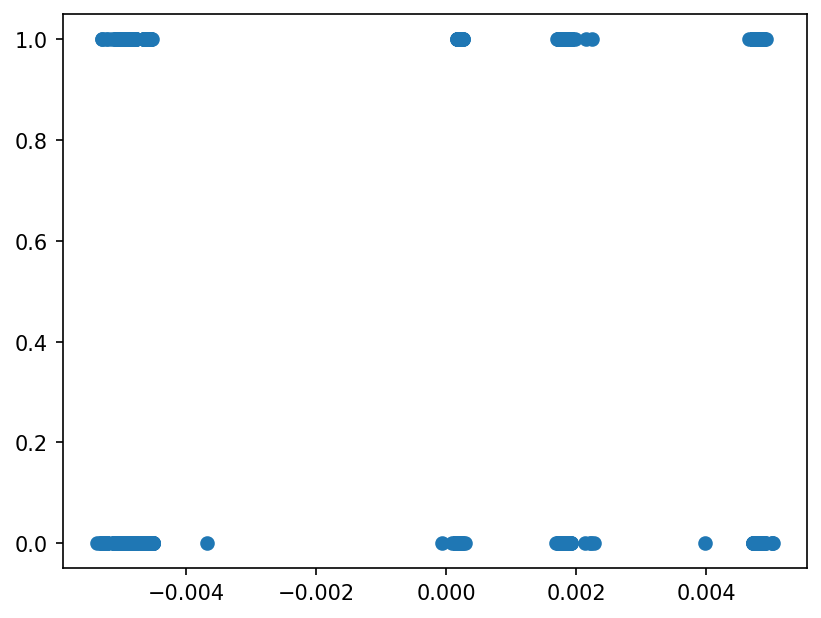

In [197]:
plt.scatter(eigenvec_df["PC0"], df_phenos["phenotype"])

In [146]:
df_phenos

,phenotypic_category,phenotype
sample_id,,
34463,WHO,0
117566,WHO,0
155633,WHO,0
155645,WHO,0
167301,WHO,0
...,...,...
843050,WHO,0
843065,WHO,0
843086,WHO,0


In [107]:
df_phenos = pd.read_csv(os.path.join(analysis_dir, "Bedaquiline", "phenos_binary.csv")).set_index("sample_id")

(2161, 223)


In [50]:
# plt.plot(np.arange(20)+1, pca.explained_variance_ratio_)

In [58]:
def read_in_matrix_compute_grm(minor_allele_counts_df, model_matrix, num_PCs=20):

    minor_allele_counts_single_model = minor_allele_counts_df.loc[model_matrix.index]
    print(minor_allele_counts_single_model.shape)
    
    # standardize values and 
    scaler = StandardScaler()
    minor_allele_counts_single_model = scaler.fit_transform(minor_allele_counts_single_model.values)
    grm = np.cov(minor_allele_counts_single_model)
    
    # standardize GRM as well and run PCA
    pca = PCA(num_PCs)
    pca.fit(scaler.fit_transform(grm))
    
    eigenvec = pca.components_.T
    eigenvec_df = pd.DataFrame(eigenvec)
    eigenvec_df["sample_id"] = model_matrix.index.values
    eigenvec_df = eigenvec_df.set_index("sample_id")
    eigenvec_df.columns = [f"PC{num}" for num in range(num_PCs)]
    
    print(sum(pca.explained_variance_ratio_))
    return eigenvec_df

In [89]:
bdq_eigenvec = read_in_matrix_compute_grm(minor_allele_counts, model_matrix, num_PCs=20)

# add lineages for plotting
#bdq_eigenvec = bdq_eigenvec.merge(lineages_df, left_index=True, right_on="Sample ID", how="left")
#bdq_eigenvec["Primary_Lineage"] = bdq_eigenvec["Lineage_1"].str[0]

(2161, 6815)
0.9764757860072821


In [121]:
final_df.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,neutral_pval,BH_pval,Bonferroni_pval,neutral_BH_pval,neutral_Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
193,mmpS5_c.-74G>T,0.540876,0.399608,0.724018,0.0,1.0,0.0,0.0,1.0,1.0,1.71751,1.491239,2.062704,3) Uncertain significance


In [117]:
coef_df.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef
193,mmpS5_c.-74G>T,0.540876


In [118]:
coef_df

,mutation,coef
0,Rv0678_p.Ala102Asp,0.132214
1,Rv0678_p.Ala102Thr,0.133945
2,Rv0678_p.Ala110fs,0.095919
3,Rv0678_p.Ala112Pro,0.050553
4,Rv0678_p.Ala144fs,0.123320
...,...,...
238,PC15,-0.184642
239,PC16,-0.095002
240,PC17,0.146491
241,PC18,0.028036


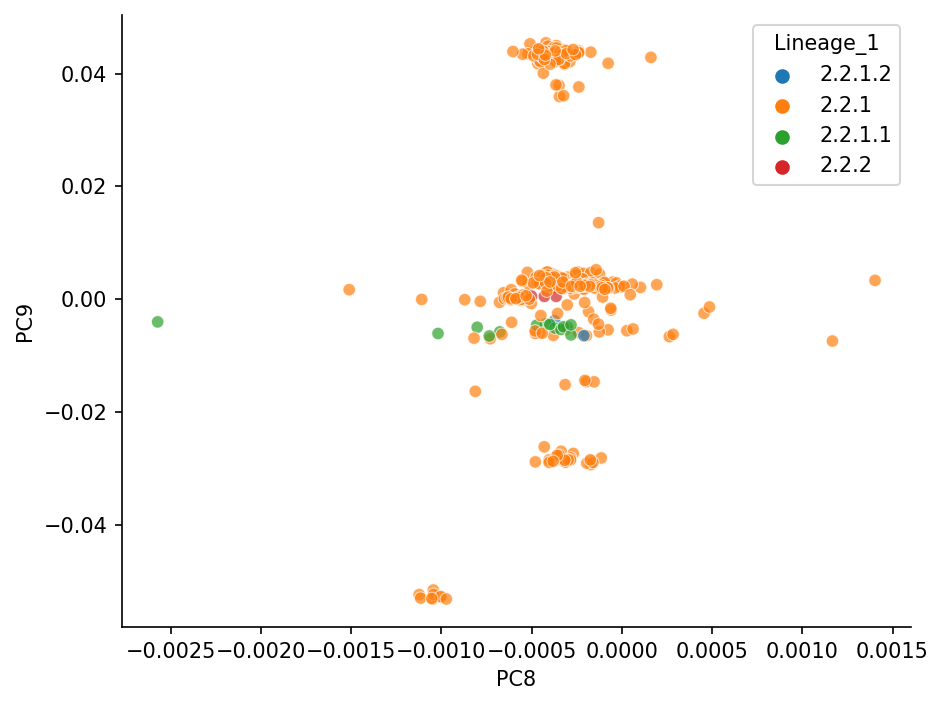

In [87]:
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                  }

sns.scatterplot(data=bdq_eigenvec.query("Primary_Lineage=='2'"), 
                x="PC8", y="PC9", 
                hue="Lineage_1",
                # hue_order=['1', '2', '3', '4', '5', '6', '7'],
                # palette=LinToColor_Dict,
                alpha=0.7,
                )

plt.tight_layout()
# plt.legend(loc="upper right", fontsize=10)
sns.despine()
#plt.savefig("Figures/PC0_PC1.png", dpi=300)
plt.show()

In [44]:
os.path.join(analysis_dir, "Isoniazid/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled")

'/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Isoniazid/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled'

In [9]:
inh_model3 = pd.read_csv(os.path.join(analysis_dir, "Isoniazid/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_analysis.csv"))
inh_model3_permutation = pd.read_csv(os.path.join(analysis_dir, "Isoniazid/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/coef_permutation.csv"))

In [7]:
inh_model3.query("mutation=='ahpC_c.-88G>A'")[['mutation', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval']]

,mutation,predicted_effect,position,confidence,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval
1337,ahpC_c.-88G>A,upstream_gene_variant,2726105,5) Not assoc w R,0.95219,0.883199,1.024105,0.084,0.288857


In [39]:
test_coef = inh_model3.query("mutation=='ahpC_c.-88G>A'")["coef"].values[0]
np.mean(np.abs(inh_model3_permutation["ahpC_c.-88G>A"]) < np.abs(test_coef))

0.827

In [43]:
np.mean(inh_model3_permutation["ahpC_c.-88G>A"] <= test_coef)

0.084

In [ ]:
np.mean(test_coef > inh_model3_permutation["ahpC_c.-88G>A"])

0.084

In [38]:
test_or = inh_model3.query("mutation=='ahpC_c.-88G>A'")["Odds_Ratio"].values[0]

# distances from OR = 1
# np.abs(np.exp(inh_model3_permutation["ahpC_c.-88G>A"].values) - 1)

# how many of those are closer than the test statistic to 1
np.mean(np.abs(np.exp(inh_model3_permutation["ahpC_c.-88G>A"]) - 1) < np.abs(test_or - 1))

0.813

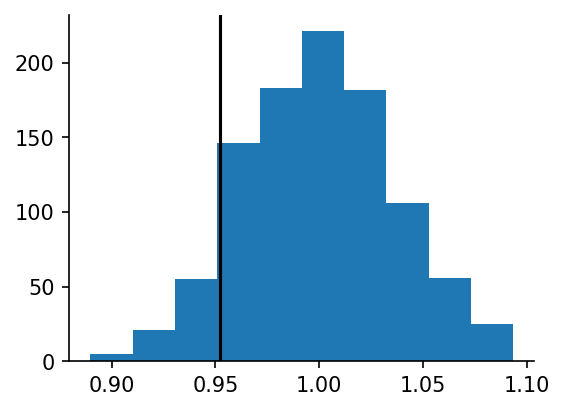

In [26]:
test_stat = inh_model3.query("mutation=='ahpC_c.-88G>A'")["Odds_Ratio"].values[0]

fig, ax = plt.subplots(figsize=(4, 3))
plt.hist(np.exp(inh_model3_permutation["ahpC_c.-88G>A"]))
plt.axvline(test_stat, color="black")
sns.despine()
plt.show()

# Lineage 2.2.1 Investigation

,Lineage,position,allele_change,tag
11,2.2.1,797736,C/T,coll2014
12,2.2.1.1,4248115,C/T,coll2014
13,2.2.1.2,3836274,G/A,coll2014


In [63]:
L221_SNP_pos = coll2014.query("Lineage.str.startswith('2.2.1')")["position"].values.astype(int)
L221_SNP_pos

array([ 797736, 4248115, 3836274])

In [60]:
input_data_dir = "/n/data1/hms/dbmi/farhat/ye12/who"
snp_dir = os.path.join(input_data_dir, "grm")

print("Creating matrix of minor allele counts")
snp_files = [os.path.join(snp_dir, fName) for fName in os.listdir(snp_dir)]
print(f"{len(snp_files)} SNP files to read from")
snp_files = [pd.read_csv(fName, usecols=[1, 2]) for fName in snp_files]

snp_combined = pd.concat(snp_files, axis=0)
snp_combined.columns = ["position", "nucleotide"]
snp_combined = snp_combined.drop_duplicates()

In [64]:
# L2.2.1.2 marker is not in the SNP table at all
snp_combined.query("position in @L221_SNP_pos")

,position,nucleotide
380,797736,C
5007,797736,T
11853,4248115,C
201923,4248115,T


In [68]:
# L2.2.1.1 marker dropped from PCA becuase it's in embB
for pos in L221_SNP_pos:
    if pos in remove_pos:
        print(pos)

4248115


In [76]:
# drop sites that are in drug resistance loci. This is a little strict because it removes entire genes, but works fine.
drugs_loci = pd.read_csv("data/drugs_loci.csv")

# add 1 to the start because it's 0-indexed
drugs_loci["Start"] += 1
assert sum(drugs_loci["End"] <= drugs_loci["Start"]) == 0

# get all positions in resistance loci
remove_pos = [list(range(int(row["Start"]), int(row["End"])+1)) for _, row in drugs_loci.iterrows()]
remove_pos = list(itertools.chain.from_iterable(remove_pos))
print(f"{len(remove_pos)} positions will be removed")
# num_pos = len(snp_combined.position.unique())
# # snp_combined = snp_combined.query("position not in @remove_pos")
# print(f"Dropped {num_pos-len(snp_combined.position.unique())} positions in resistance-determining regions")

57866 positions will be removed


In [85]:
len(list(set(remove_pos) - set(coll2014["position"].values.astype(int))))

57862

In [77]:
len(set(remove_pos) - set(coll2014["position"].values))

57862

In [78]:
set(coll2014["position"].values).intersection(remove_pos)

{764995, 4246508, 4248115, 4249732}

In [81]:
coll2014.query("position in [764995, 4246508, 4248115, 4249732]")

,Lineage,position,allele_change,tag
12,2.2.1.1,4248115,C/T,coll2014
32,4.3,764995,C/G,coll2014
45,4.4.2,4246508,G/A,coll2014
54,4.7,4249732,C/G,coll2014
